# Analyzing NYPD Historical Crime Data: Impact on academic performance 


## Abstract 

This is a breakdown of every criminal complaint report filed in NYC by the NYPD in 2011. This data is manually extracted every quarter and reviewed by the Office of Management Analysis and Planning. Each record represents a criminal complaint in NYC and includes information abot the type of crime, the location and time of enforcement. This data can be used by the public to explore the nature of criminal activity in conjunction with the Safety/Respect Scores and SAT performance. 

## Methods 

This dataset includes all valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) from 2006 to the end of last year (2017). For additional details, please see the [data dictionary](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i). 

# ETL

In [29]:
#Libraries used for analysis and visualizations 

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
import folium
from folium.plugins import HeatMap
from random import sample 
import branca.colormap as cm


In [2]:
crime_2011 = pd.read_csv('schools/NYPD_Complaint_Data_Historic_2011.csv', index_col = 'CMPLNT_NUM')
crime_2011.head()

,CMPLNT_FR_DT,CMPLNT_TO_DT,RPT_DT,OFNS_DESC,PD_CD,LAW_CAT_CD,BORO_NM,Latitude,Longitude,PATROL_BORO,VIC_AGE_GROUP
CMPLNT_NUM,,,,,,,,,,,
519234712,1/1/2011,1/1/2011,1/21/2019,SEX CRIMES,177.0,FELONY,BROOKLYN,40.648650,-73.950336,PATROL BORO BKLYN SOUTH,<18
495207193,1/1/2011,2/13/2019,2/13/2019,PETIT LARCENY,338.0,MISDEMEANOR,MANHATTAN,40.862255,-73.926297,PATROL BORO MAN NORTH,45-64
527650130,1/1/2011,NaN,2/8/2019,SEX CRIMES,177.0,FELONY,BRONX,40.816392,-73.895296,PATROL BORO BRONX,<18
512891731,1/1/2011,NaN,3/7/2019,FRAUDS,718.0,MISDEMEANOR,BROOKLYN,40.633193,-73.941884,PATROL BORO BKLYN SOUTH,45-64
234370701,1/1/2011,NaN,4/5/2019,RAPE,157.0,FELONY,QUEENS,40.745253,-73.870063,PATROL BORO QUEENS NORTH,<18


In [3]:
crime_2011.isnull().sum()

CMPLNT_FR_DT          0
CMPLNT_TO_DT     134235
RPT_DT                0
OFNS_DESC          1625
PD_CD               494
LAW_CAT_CD            0
BORO_NM             499
Latitude             54
Longitude            54
PATROL_BORO         494
VIC_AGE_GROUP    170162
dtype: int64

A significant portion of the CMPLNT_TO_DT has NaN values. Based on the dictionary description, we can exclude it since it has no influence on our analysis. We are not interested in VIC_AGE_GROUP either 


In [4]:
crime_2011.dtypes

CMPLNT_FR_DT      object
CMPLNT_TO_DT      object
RPT_DT            object
OFNS_DESC         object
PD_CD            float64
LAW_CAT_CD        object
BORO_NM           object
Latitude         float64
Longitude        float64
PATROL_BORO       object
VIC_AGE_GROUP     object
dtype: object

In [5]:
# Keeping all rows with Borough Names 
crime_df = crime_2011[crime_2011['BORO_NM'].notna()]

crime_df.head()

,CMPLNT_FR_DT,CMPLNT_TO_DT,RPT_DT,OFNS_DESC,PD_CD,LAW_CAT_CD,BORO_NM,Latitude,Longitude,PATROL_BORO,VIC_AGE_GROUP
CMPLNT_NUM,,,,,,,,,,,
519234712,1/1/2011,1/1/2011,1/21/2019,SEX CRIMES,177.0,FELONY,BROOKLYN,40.648650,-73.950336,PATROL BORO BKLYN SOUTH,<18
495207193,1/1/2011,2/13/2019,2/13/2019,PETIT LARCENY,338.0,MISDEMEANOR,MANHATTAN,40.862255,-73.926297,PATROL BORO MAN NORTH,45-64
527650130,1/1/2011,NaN,2/8/2019,SEX CRIMES,177.0,FELONY,BRONX,40.816392,-73.895296,PATROL BORO BRONX,<18
512891731,1/1/2011,NaN,3/7/2019,FRAUDS,718.0,MISDEMEANOR,BROOKLYN,40.633193,-73.941884,PATROL BORO BKLYN SOUTH,45-64
234370701,1/1/2011,NaN,4/5/2019,RAPE,157.0,FELONY,QUEENS,40.745253,-73.870063,PATROL BORO QUEENS NORTH,<18


In [6]:
crime_df= crime_df[['CMPLNT_FR_DT', 'OFNS_DESC', 'LAW_CAT_CD', 'BORO_NM','Latitude','Longitude', 'PATROL_BORO']]

df_clean =  crime_df[crime_df['Latitude'].notna() & crime_df['Longitude'].notna() & crime_df['OFNS_DESC']]
df_clean.isnull().sum()
crime_cleaned = df_clean.rename({'CMPLNT_FR_DT':'Date of Complaint',
                                'OFNS_DESC': 'Offense Desc.',
                                 'BORO_NM':'Borough',
                                'LAW_CAT_CD':'Crime Classification',
                                'PATROL_BORO': 'Patrol Borough'}, axis =1)

crime_cleaned.head()

,Date of Complaint,Offense Desc.,Crime Classification,Borough,Latitude,Longitude,Patrol Borough
CMPLNT_NUM,,,,,,,
519234712,1/1/2011,SEX CRIMES,FELONY,BROOKLYN,40.648650,-73.950336,PATROL BORO BKLYN SOUTH
495207193,1/1/2011,PETIT LARCENY,MISDEMEANOR,MANHATTAN,40.862255,-73.926297,PATROL BORO MAN NORTH
527650130,1/1/2011,SEX CRIMES,FELONY,BRONX,40.816392,-73.895296,PATROL BORO BRONX
512891731,1/1/2011,FRAUDS,MISDEMEANOR,BROOKLYN,40.633193,-73.941884,PATROL BORO BKLYN SOUTH
234370701,1/1/2011,RAPE,FELONY,QUEENS,40.745253,-73.870063,PATROL BORO QUEENS NORTH


In [7]:
date = crime_cleaned['Date of Complaint'].str.split("/", n=3, expand = True)

crime_cleaned['Day'] = date[1].astype(int)
crime_cleaned['Month'] = date[0].astype(int)


# Data Exploration

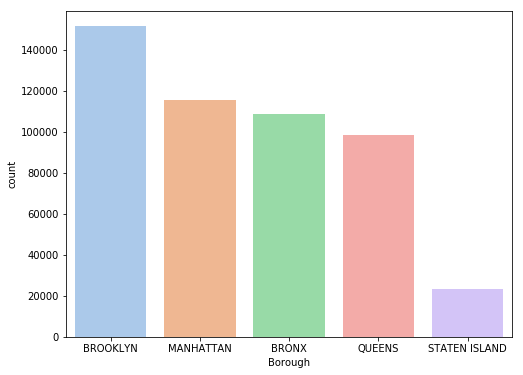

In [8]:
f, ax = plt.subplots(figsize=(8,6))

sns.countplot(x = 'Borough', data=crime_cleaned, palette = 'pastel')

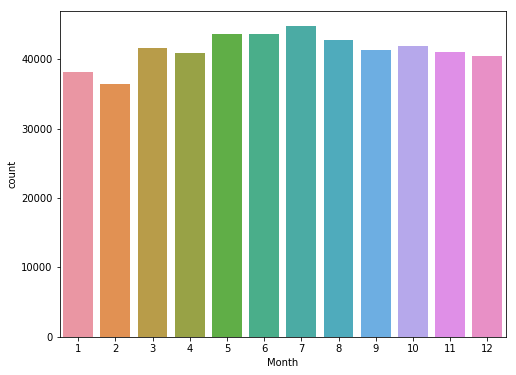

In [10]:
f, ax = plt.subplots(figsize=(8,6))

sns.countplot(x='Month', data =crime_cleaned)

In [36]:
positions = []

positions = list(zip(crime_cleaned['Latitude'], crime_cleaned['Longitude']))
tiles = 'Stamen Terrain'

base_map = folium.Map(location=[40.75,-73.98], zoom_start=10, tiles = tiles)

pos_sample = sample(positions, 50000)
HeatMap(pos_sample, radius =8).add_to(base_map)


colormap = cm.LinearColormap(colors=['lightblue','green', 'yellow', 'red'])
colormap.caption = 'Heat Map of Crime in New York City'
colormap.add_to(base_map)

base_map